In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data


In [3]:
#df = pd.read_csv('yahoo_stock.csv', parse_dates = ['Date'], index_col = 'Date')
df = get_data("^GSPC")
df = df.drop('ticker', axis=1)
df.head()

,open,high,low,close,adjclose,volume
1970-03-25,0.0,91.070000,88.110001,89.769997,89.769997,17500000
1970-03-26,0.0,90.650002,89.180000,89.919998,89.919998,11350000
1970-03-30,0.0,90.410004,88.910004,89.629997,89.629997,9600000
1970-03-31,0.0,90.169998,88.849998,89.629997,89.629997,8370000
1970-04-01,0.0,90.620003,89.300003,90.070000,90.070000,9810000


<Axes: >

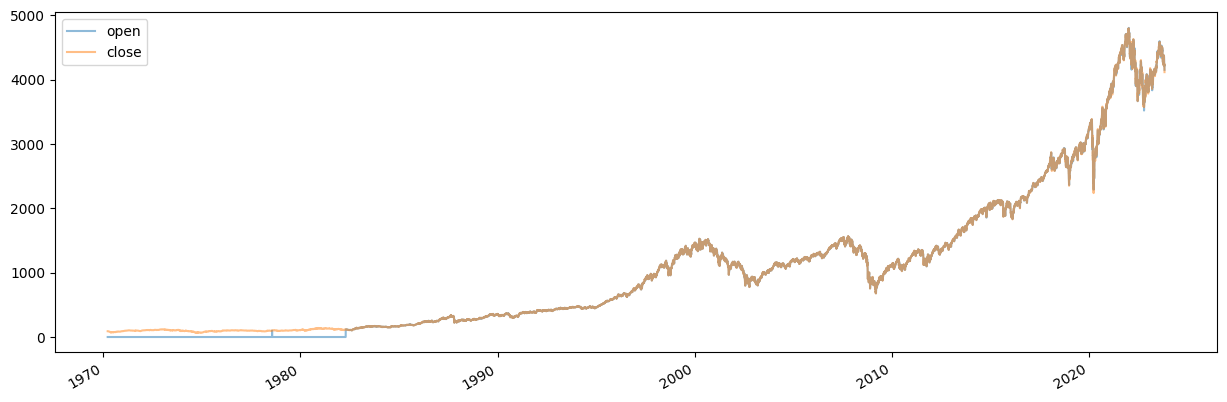

In [4]:
df.describe()

df[['open', 'close']].plot(figsize = (15, 5), alpha = 0.5)

Ploting the time series

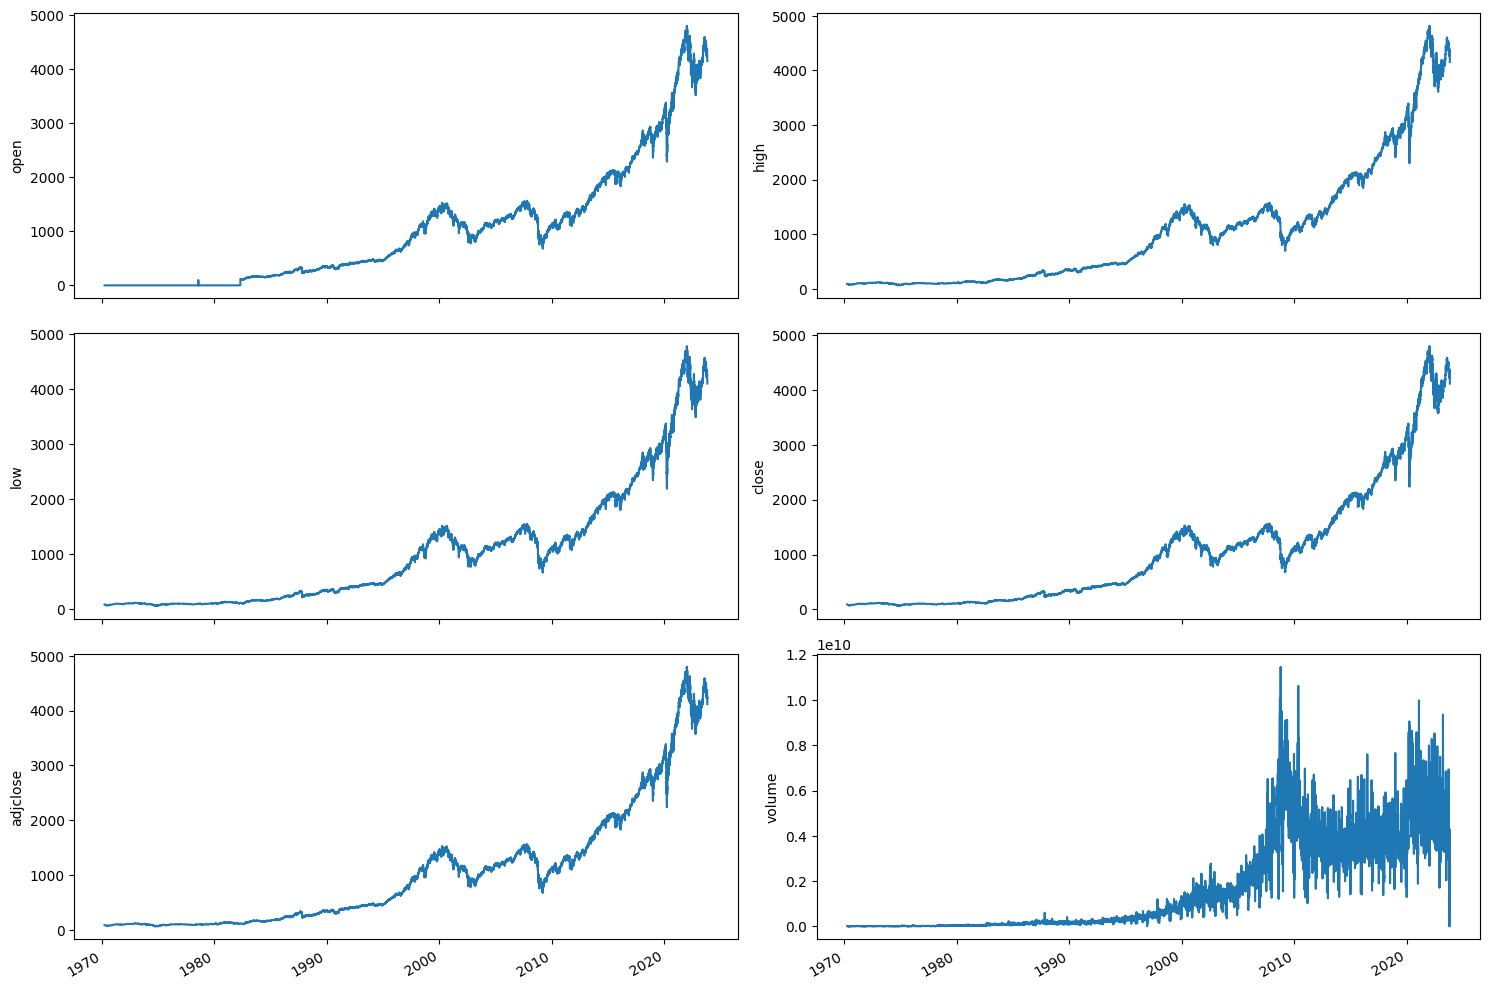

In [5]:
#df.plot(x='Date',y=var)

labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    #plt.scatter(df['Date'],df[label])
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

Removing weekends

In [6]:
#df = df[df.index.weekday < 5]

Chossing variable to study

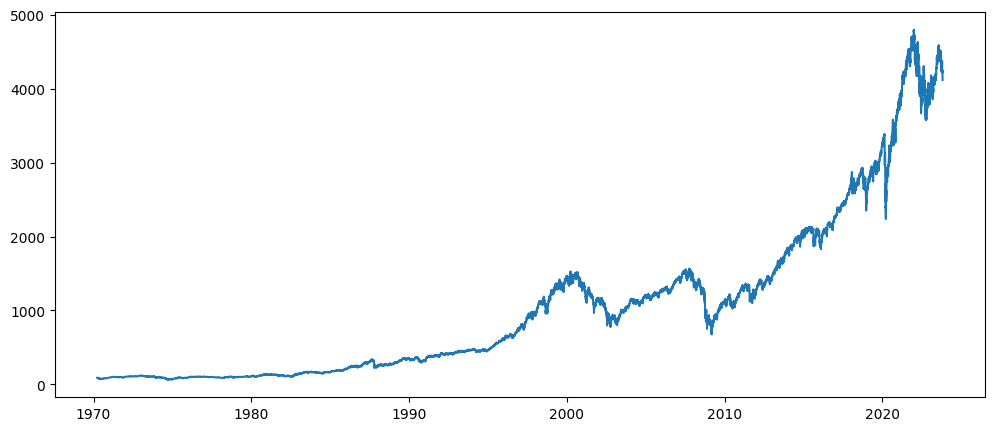

In [7]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

Decomposing the time series

In [8]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', extrapolate_trend='freq')
    
    return result_mul, result_add

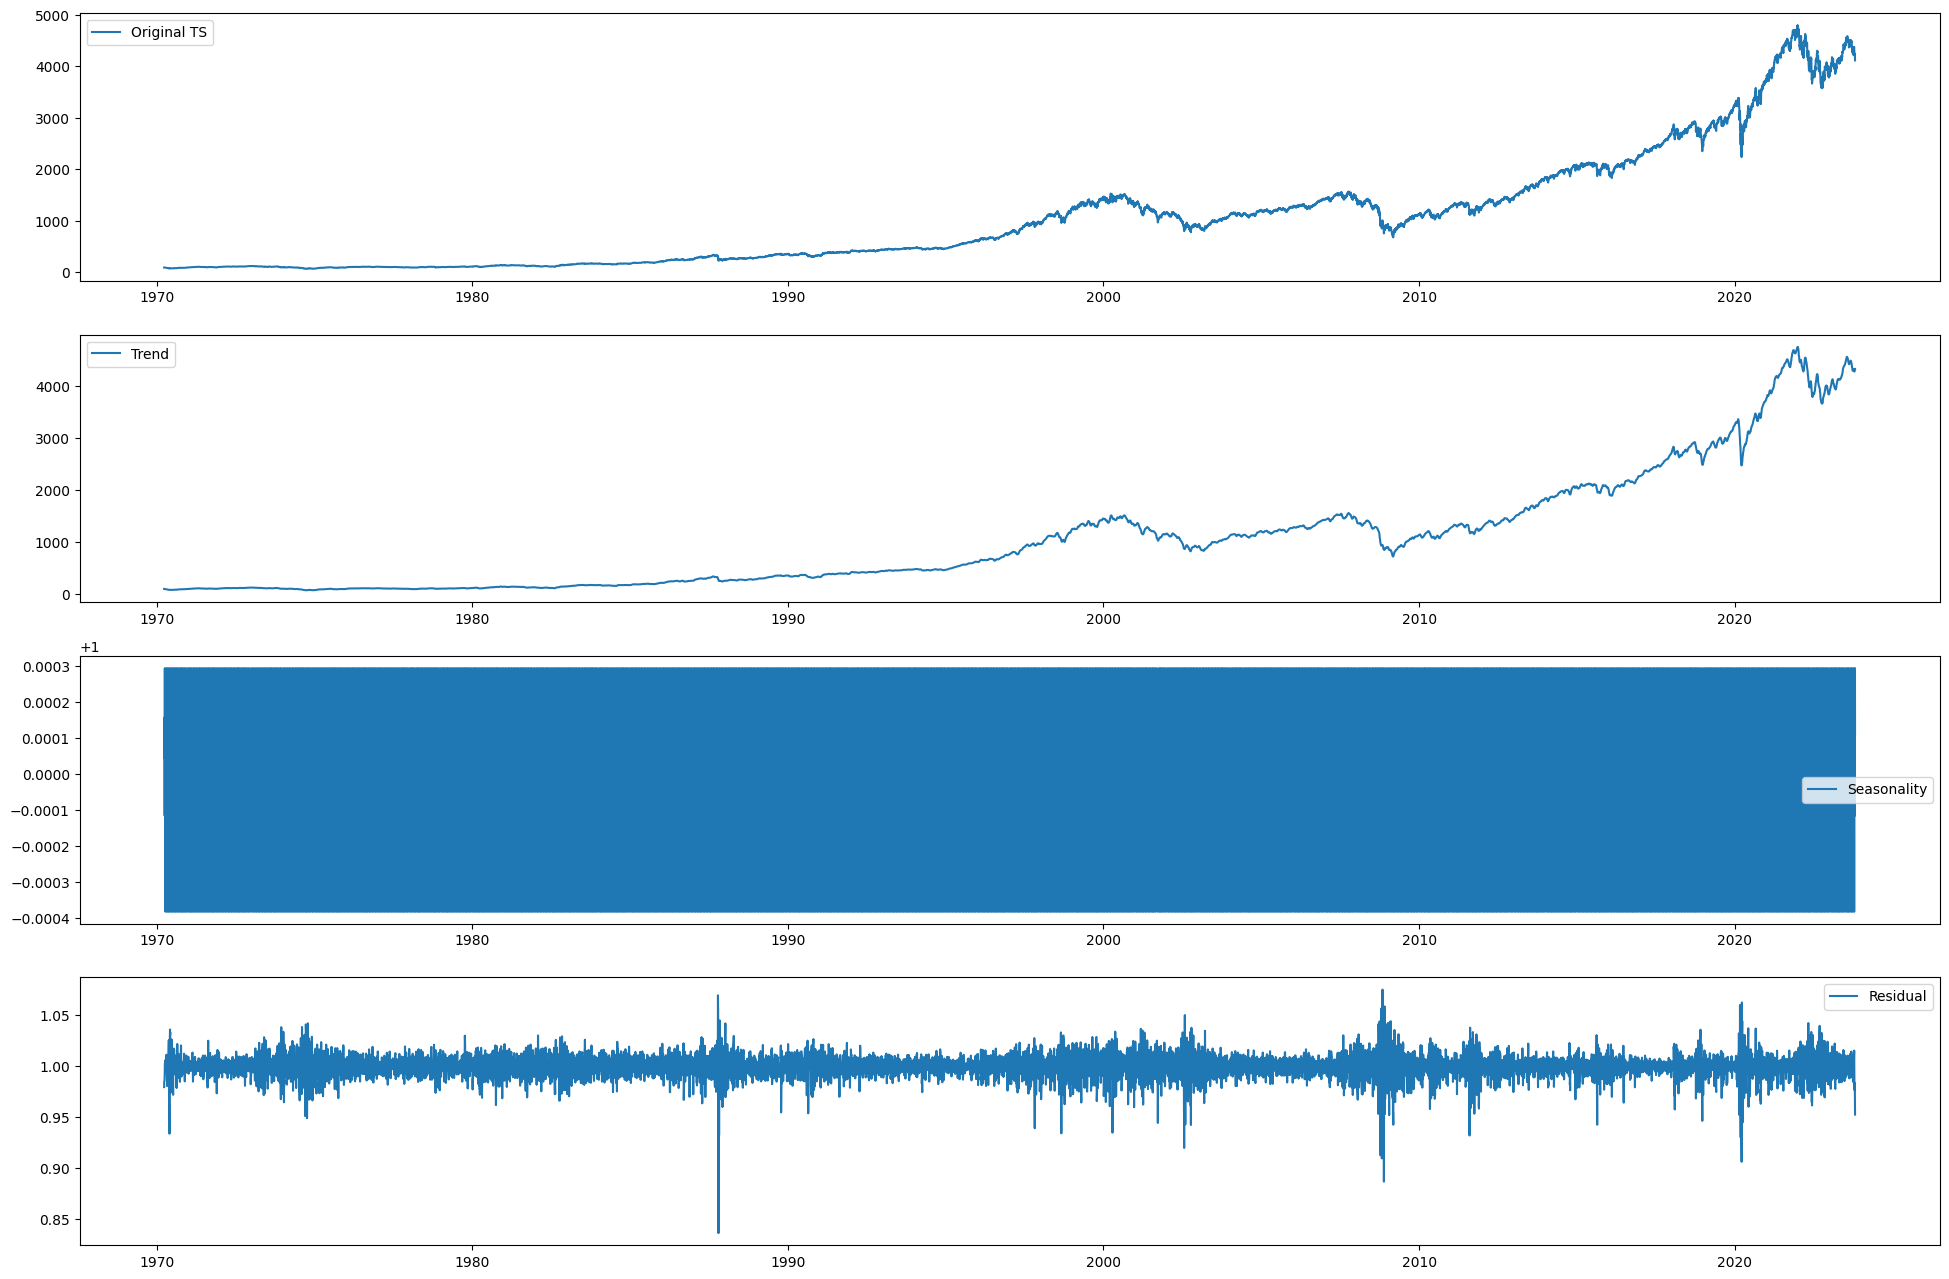

In [40]:
decompose_add=seasonal_decompose(df[var], model='multiplicative', period=12, extrapolate_trend='freq')
plt.figure(figsize=(24,16))
plt.subplot(411)
plt.plot(df[var], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')
plt.show()


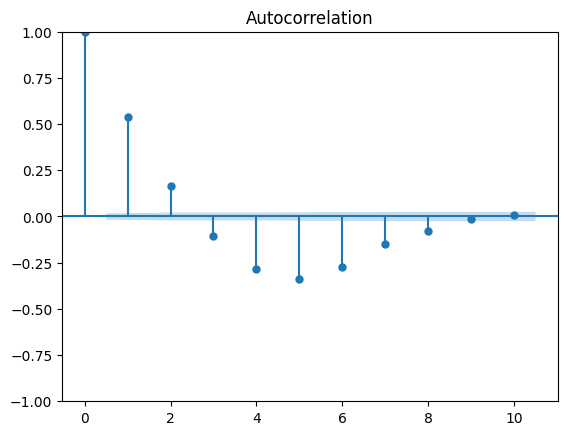

In [41]:
fig = tsaplots.plot_acf(decompose_add.resid, lags=10)
plt.show()

Lag plots

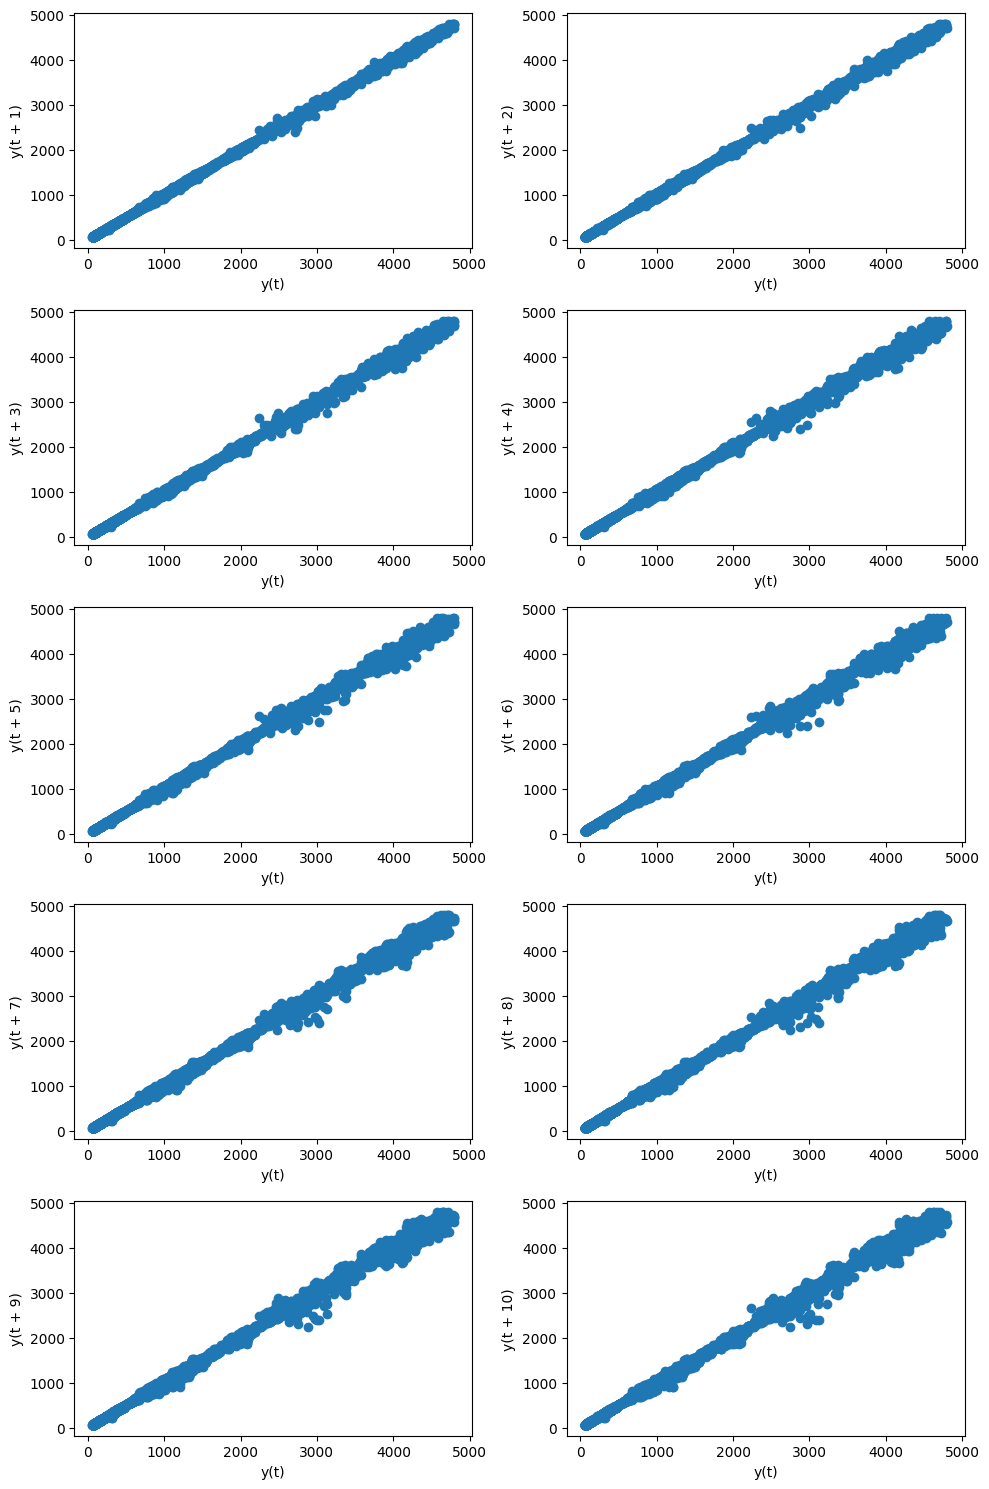

In [11]:
plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


ACF Plot

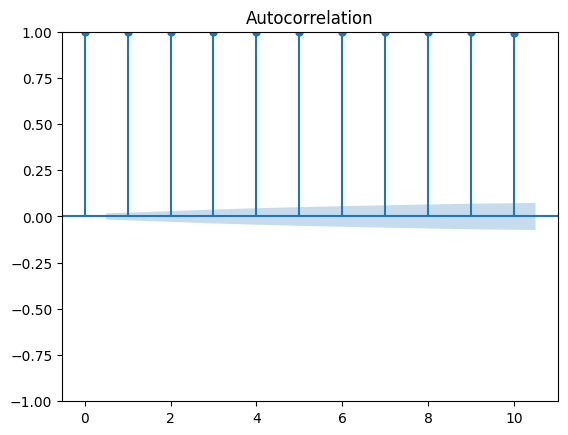

[1.         0.99955689 0.99913188 0.99868985 0.99823981 0.99780383
 0.99736172 0.99692608 0.99646338 0.99600889 0.9955303 ]


In [12]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=10)
plt.show()
print(acf)

Analysing the daily difference

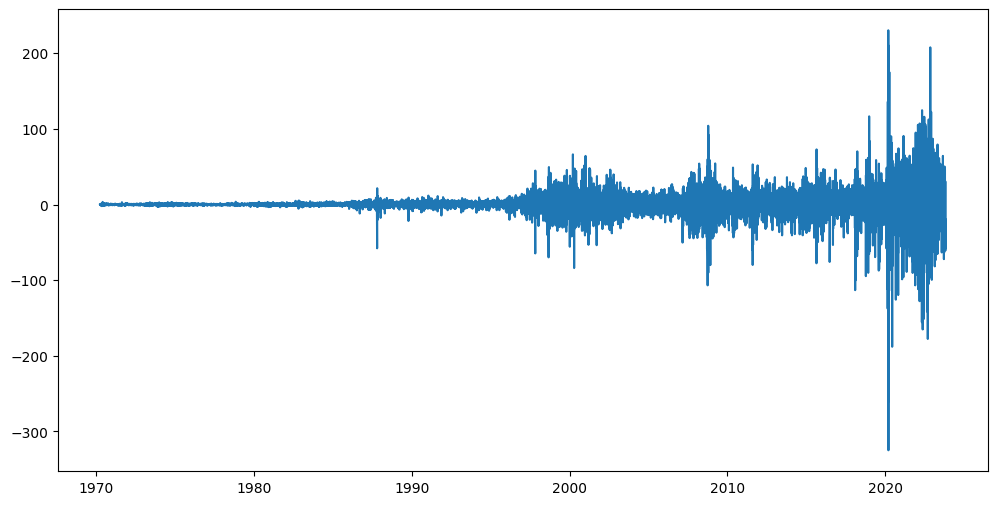

In [13]:
daily_diff = df.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.show()

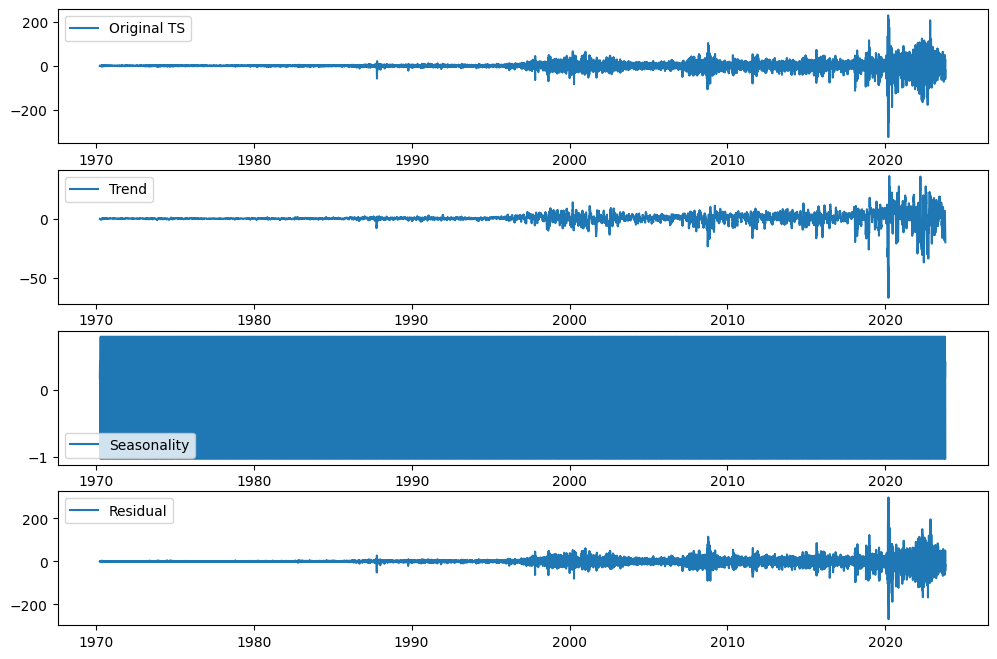

In [14]:
decompose_add=seasonal_decompose(daily_diff[var][1:], model='additive', period=12)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(daily_diff[var], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')
plt.show()

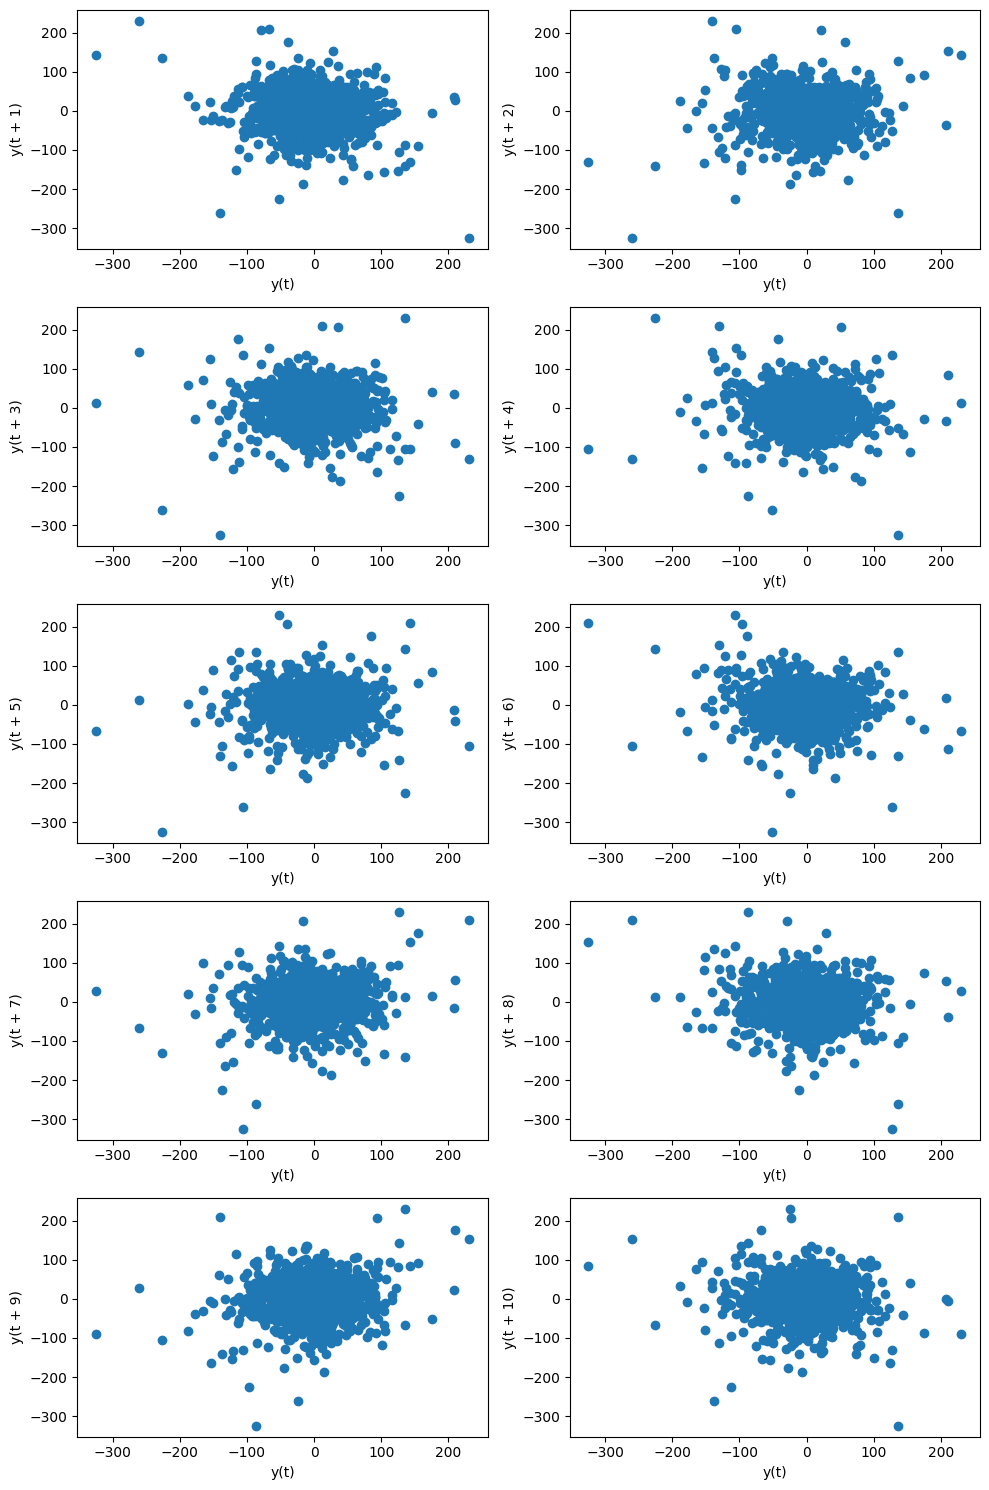

In [15]:
plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

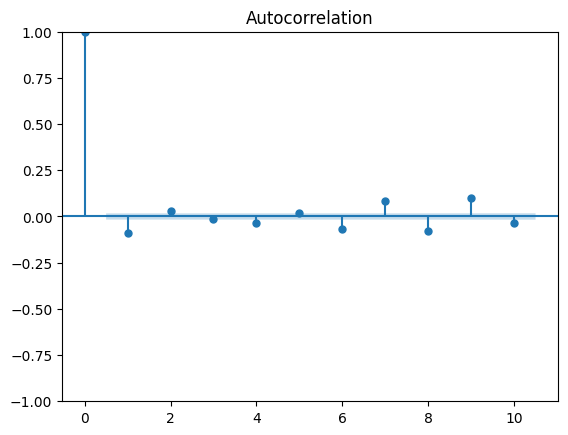

In [16]:
acf= sm.tsa.acf(daily_diff[var][1:])
fig = tsaplots.plot_acf(daily_diff[var][1:], lags=10)
plt.show()

Analysing the data monthly

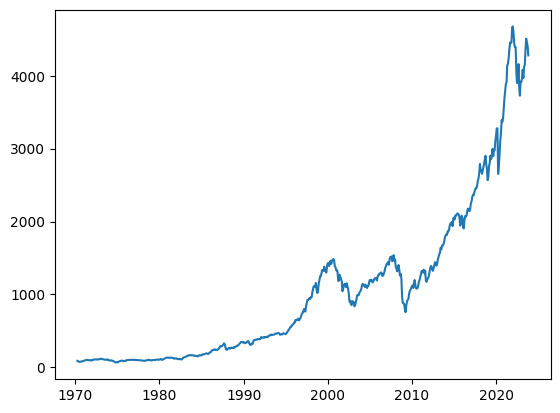

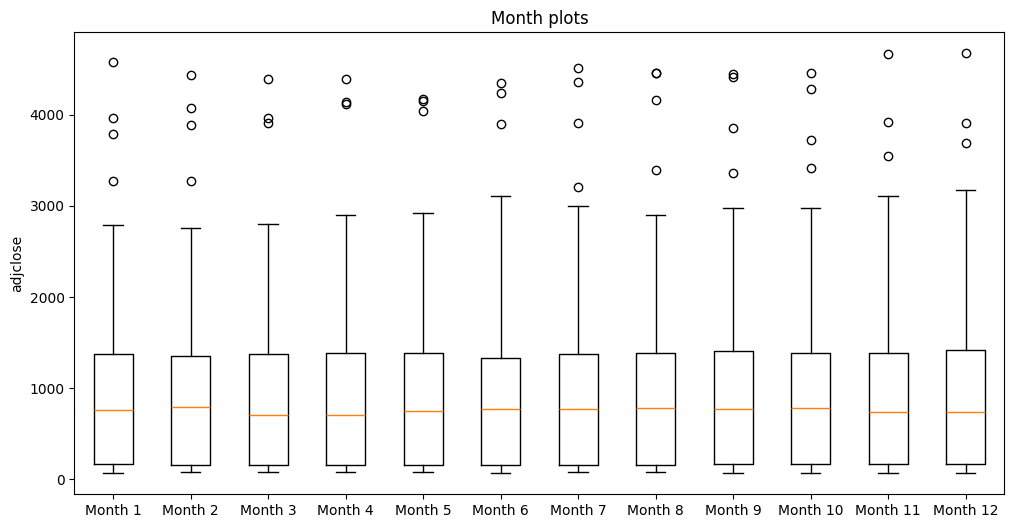

In [17]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()


The evolution of the monthly difference

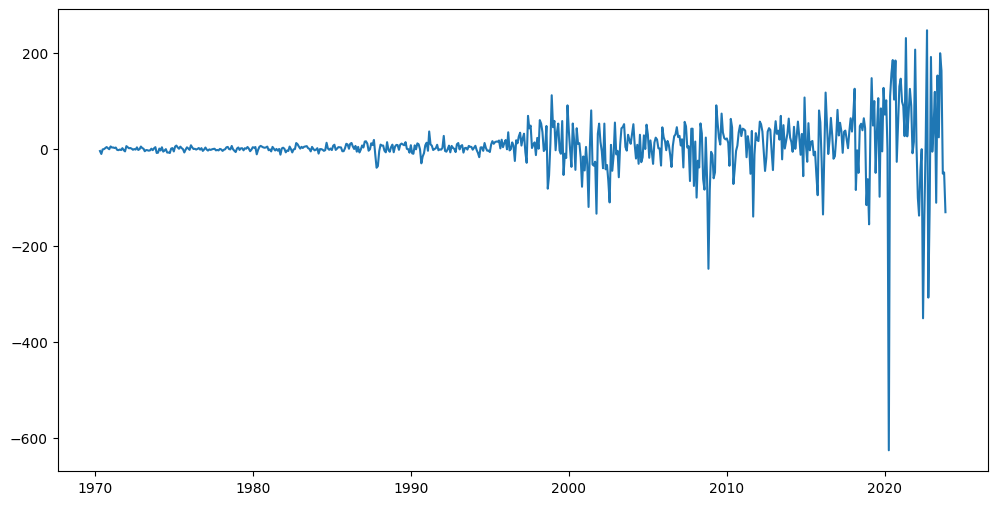

In [18]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

Analysing the box-cox trangormation

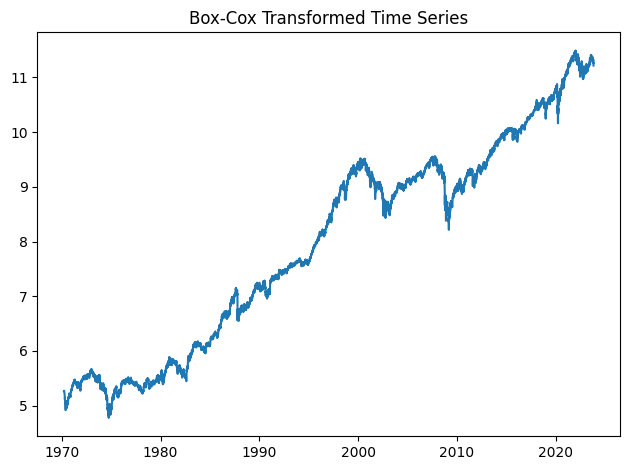

Optimal lambda value: 0.06845813790305294


In [19]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

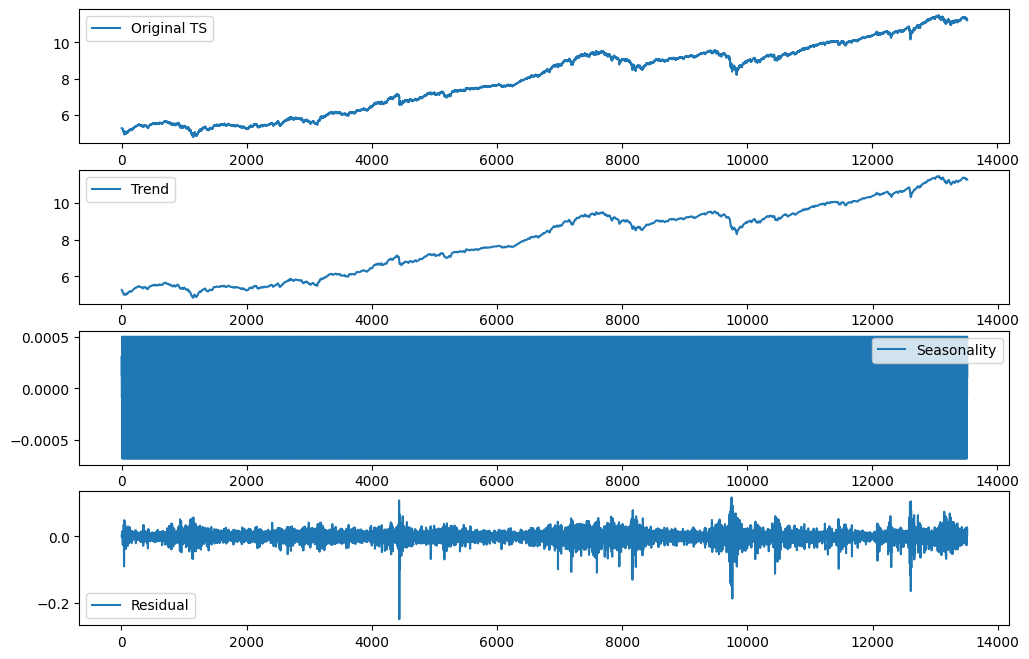

In [20]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=12)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

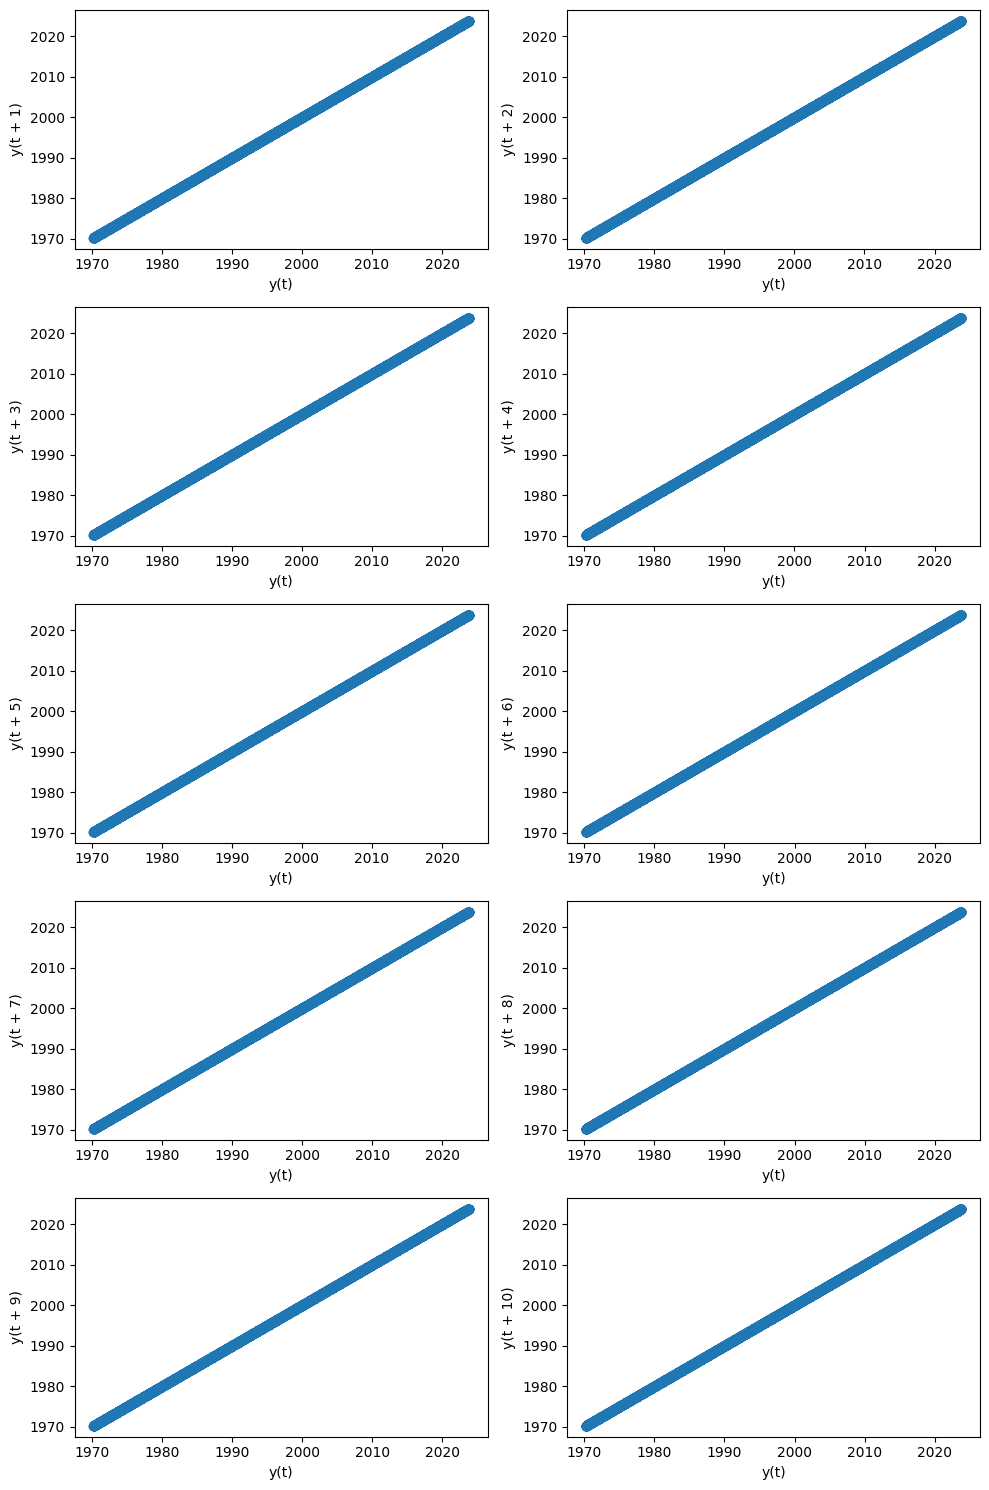

In [21]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

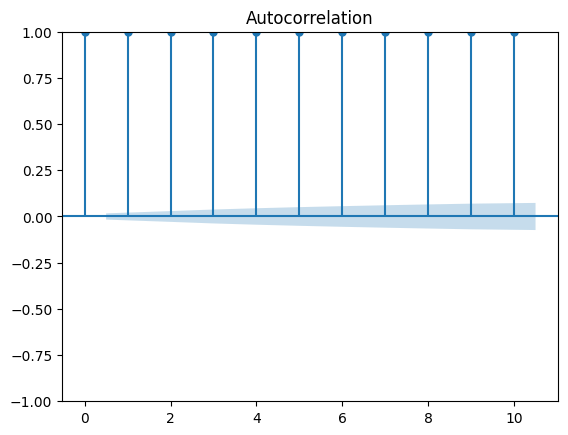

In [22]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()